In [9]:
%load_ext autoreload
%autoreload 2

from discontinuum.providers import usgs
from discontinuum.utils import aggregate_to_daily

import xarray as xr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# setup

# Choptank River at Greensboro, MD
site = "01491000" 
start_date = "1979-10-01"
end_date = "2011-09-30"

# SF Coeur D Alene River 
site = "12413470"
start_date = "1988-10-01" 
end_date = "2021-09-30" 

characteristic = 'Inorganic nitrogen (nitrate and nitrite)'
#characteristic = 'Phosphorus'
fraction = 'Dissolved'

In [11]:
# download data

daily = usgs.get_daily(site=site, start_date=start_date, end_date=end_date)
samples = usgs.get_samples(site=site, start_date=start_date, end_date=end_date, characteristic=characteristic, fraction=fraction)

samples = aggregate_to_daily(samples)

training_data = xr.merge([samples, daily], join='inner')

/Users/thodson/micromamba/envs/discontinuum-dev/lib/python3.11/site-packages/dataretrieval/wqp.py:494: UserWarning: USGS discrete water quality data availability and format are changing. Beginning in March 2024 the data obtained from legacy profiles will not include new USGS data or recent updates to existing data. To view the status of changes in data availability and code functionality, visit: https://doi-usgs.github.io/dataRetrieval/articles/Status.html. If you have additional questions about these changes, email CompTools@usgs.gov.
  warnings.warn(('USGS discrete water quality data availability '
/Users/thodson/Desktop/dev/software/discontinuum/discontinuum/providers/usgs.py:241: UserWarning: Censored values have been removed from the dataset.
  warnings.warn("Censored values have been removed from the dataset.")


In [12]:
%%time
# fit model

from discontinuum.models import LoadestGP

model = LoadestGP()
model.fit(target=training_data['concentration'], covariates=training_data[['time','flow']])

MAP ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   2% 0:01:32 logp = -144.41, ||grad|| = 0.0040614

CPU times: user 7.51 s, sys: 1.19 s, total: 8.7 s
Wall time: 8.44 s


<Axes: xlabel='time', ylabel='Inorganic nitrogen (nitrate\nand nitrite) [mg/l as N]'>

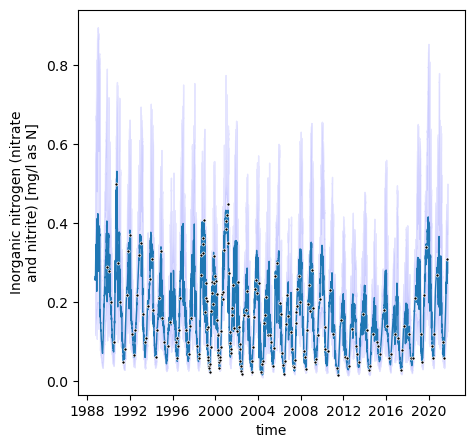

In [13]:
# plot result

model.plot_concentration(daily[['time','flow']])

In [14]:
sim = model.sample(daily[['time','flow']])

<Axes: title={'center': 'load'}, xlabel='[time]'>

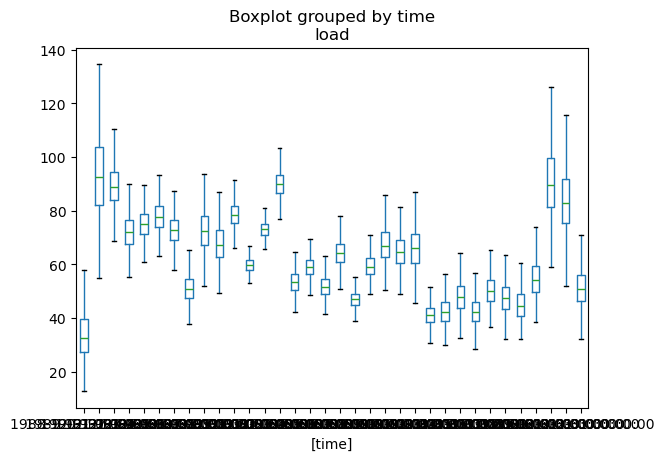

In [30]:
#compute load then do
# note first 
sim.resample(time='YE').sum().to_dataframe(name='load').boxplot(by='time', showfliers=False, grid=False)

In [65]:
x = model.predict(daily[['time','flow']])

In [89]:
x[0].attrs

{'pcode': '00631',
 'standard_name': 'concentration',
 'long_name': 'Inorganic nitrogen (nitrate and nitrite)',
 'units': 'mg/l as N',
 'suffix': None,
 'conversion': 1.0}

In [51]:
test = sim.data.reshape(1000,-1)

In [81]:
test2 = xr.DataArray(test, dims=['draw','time'])

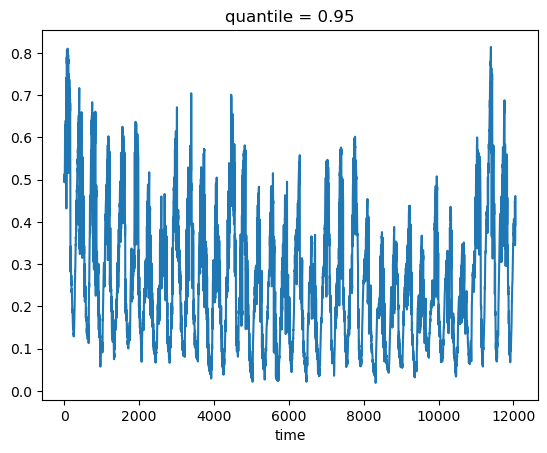

In [85]:
test2.quantile(0.95, dim='draw').plot()

In [63]:
import numpy as np
upper = np.percentile(test, 97.5, axis=0)

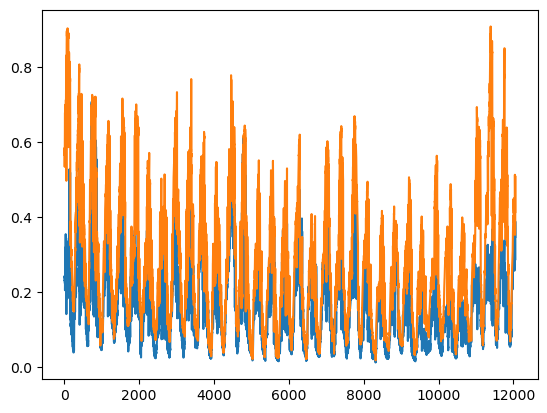

In [64]:
import matplotlib.pyplot as plt
plt.plot(test[0,:])
plt.plot(upper)

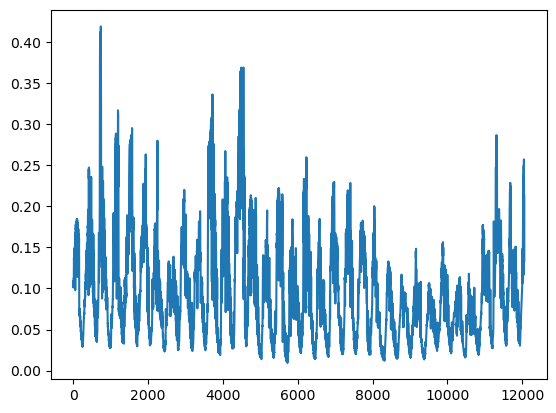

In [62]:
plt.plot(upper)